In [2]:
# HOXB13 HER2/HOXB13 co-amp dependencies and drug sensitivities
# 4/10/2023
# Esther Rheinbay


In [3]:
import sys
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, mannwhitneyu, fisher_exact
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

figdir = '/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/Manuscript/Figures/'

In [4]:
# CCLE sample info and expression data
sample_info = pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/CCLE/sample_info_22Q2.csv', sep=',', header=0, index_col=0) 

# "full" expression has XIST (not under top downloads, but under "All downloads" list)
ccle_exp = pd.read_csv('/Users/esther/Documents/Reference_data/DepMap/CCLE_expression_full_22Q2.csv', sep=',', header=0, index_col=0)

# trim column names to just gene names: 
ccle_exp.columns = map(lambda x: x.split(' ')[0], ccle_exp.columns.values)



In [5]:
# 4/6 HOXB13/HER2 amp lines and 1/7 HER2only are NOT in the CRISPR KO set, need to use RNAi! 
# obtained RNAi (RNAi (Achilles+DRIVE+Marcotte, DEMETER2)) and PRISM primary and repurposing screen data (Drug sensitivity AUC (PRISM Repurposing Secondary Screen, Drug sensitivity (PRISM Repurposing Primary Screen))
# from the DepMap download portal for the select list of cell lines below 

dependencies = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/RNAi_(Achilles+DRIVE+Marcotte,_DEMETER2)_subsetted.csv', sep=',', header=0, index_col=0) 
#dependencies.columns = map(lambda x: x.split(' ')[0], dependencies.columns.values)

prism_primary = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/Drug_sensitivity_(PRISM_Repurposing_Primary_Screen)_subsetted.csv', sep=',', header=0, index_col=0) 
prism_secondary = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NAsdropped.csv', sep=',', header=0, index_col=0) 




In [6]:
# coamp cell lines from Irene's scatterplot
HER2_HOXB13_coamp_cell_lines = ['HCC202', 'BT-474', 'EFM-192A', 'HCC2218', 'ZR-75-30', 'HCC1419']

['HER2_HOXB13_coamp_cell_line']

# DepMap IDs
HER2_HOXB13_coamp = sample_info[sample_info.cell_line_name.isin(HER2_HOXB13_coamp_cell_lines)].index

# other breast cancer lines

# confirm Irene's lines are annotated as HER2+
print(sample_info[(sample_info.cell_line_name.isin(HER2_HOXB13_coamp_cell_lines))][['cell_line_name', 'lineage_molecular_subtype']])
# HER2 only gained/amp lines
print(sample_info[(sample_info.primary_disease=='Breast Cancer')& (sample_info.lineage_molecular_subtype=='HER2_amp') & ~(sample_info.cell_line_name.isin(HER2_HOXB13_coamp_cell_lines))])

HER2only = sample_info[(sample_info.primary_disease=='Breast Cancer')& (sample_info.lineage_molecular_subtype=='HER2_amp') & ~(sample_info.cell_line_name.isin(HER2_HOXB13_coamp_cell_lines))].index


           cell_line_name lineage_molecular_subtype
DepMap_ID                                          
ACH-000117       EFM-192A                  HER2_amp
ACH-000277        HCC1419                  HER2_amp
ACH-000725         HCC202                  HER2_amp
ACH-000755        HCC2218                  HER2_amp
ACH-000828       ZR-75-30                  HER2_amp
ACH-000927         BT-474                  HER2_amp
            cell_line_name stripped_cell_line_name           CCLE_Name alias  \
DepMap_ID                                                                      
ACH-000017         SK-BR-3                   SKBR3        SKBR3_BREAST   NaN   
ACH-000248           AU565                   AU565        AU565_BREAST   NaN   
ACH-000554        UACC-893                 UACC893      UACC893_BREAST   NaN   
ACH-000759  MDA-MB-175-VII             MDAMB175VII  MDAMB175VII_BREAST   NaN   
ACH-000876      MDA-MB-415                MDAMB415     MDAMB415_BREAST   NaN   
ACH-000910      MDA-MB-4

Note that some HER_amp lines are annotated as HER2neg, but here we care about genomic amplification

In [7]:
# Compare dependencies between HER2/HOXB13 coamp, and HER2 only amp
# Dependency analysis
dep_transposed = dependencies.transpose()

diff_dependencies = dep_transposed.apply(lambda x: ttest_ind(x[HER2_HOXB13_coamp].dropna(), x[HER2only].dropna(), nan_policy='omit').pvalue, axis=1).to_frame()
diff_dependencies.columns = ['ttest_p']
diff_dependencies['avg_HER2HOXB13'] = diff_dependencies.apply(lambda x: np.nanmean(dep_transposed.loc[x.name][HER2_HOXB13_coamp]), axis=1)
diff_dependencies['avg_HER2only'] = diff_dependencies.apply(lambda x: np.nanmean(dep_transposed.loc[x.name][HER2only]), axis=1)
diff_dependencies['difference'] = diff_dependencies.apply(lambda x: x.avg_HER2HOXB13-x.avg_HER2only, axis=1)
diff_dependencies.dropna(inplace=True)
diff_dependencies['qval'] = fdrcorrection(diff_dependencies.ttest_p)[1]
diff_dependencies['log10p'] = diff_dependencies.apply(lambda x: -np.log10(x.ttest_p), axis=1)


/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_96159/126000815.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  diff_dependencies = dep_transposed.apply(lambda x: ttest_ind(x[HER2_HOXB13_coamp].dropna(), x[HER2only].dropna(), nan_policy='omit').pvalue, axis=1).to_frame()
/Users/esther/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/esther/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [8]:
# no significantly different dependencies
diff_dependencies[diff_dependencies.qval<0.1]

,ttest_p,avg_HER2HOXB13,avg_HER2only,difference,qval,log10p


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Gene effect score difference HER2+HOXB13/HER2 only')

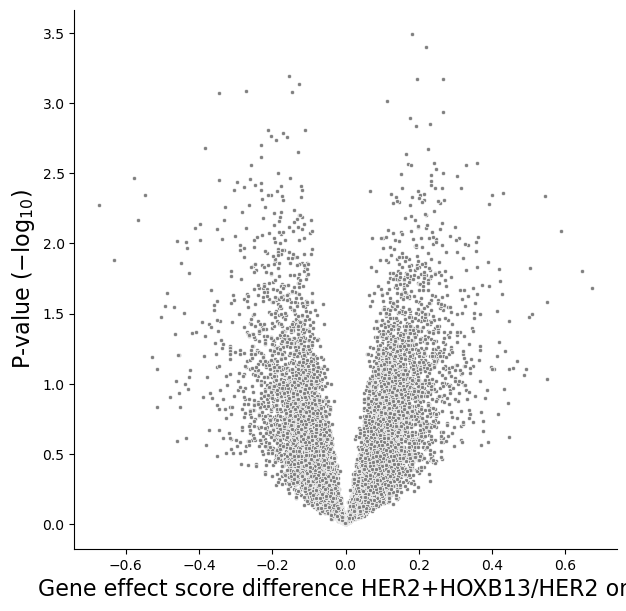

In [9]:
# volcano plot for dependencies 
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x = 'difference', y = 'log10p', data =diff_dependencies, color='grey', marker = '.', ax=ax)
sns.scatterplot(x = 'difference', y = 'log10p', data = diff_dependencies[diff_dependencies.qval<0.1], color='red', label = 'q<0.01')

sns.despine()
ax.legend(loc='upper right', frameon=False, fontsize=14)
ax.set_ylabel('P-value ($\mathregular{-log_{10}}$)', fontsize=16)
ax.set_xlabel('Gene effect score difference HER2+HOXB13/HER2 only', fontsize=16)


In [10]:
# sort by difference, any interesting hits? 
diff_dependencies.sort_values(by='difference')[0:10]


,ttest_p,avg_HER2HOXB13,avg_HER2only,difference,qval,log10p
CNOT1,0.005360,-1.113225,-0.440141,-0.673084,0.848414,2.270799
KIF18A,0.013128,-0.870277,-0.238395,-0.631882,0.848414,1.881805
ZMAT5,0.003447,-0.844509,-0.267292,-0.577217,0.848414,2.462540
DYNC1LI2,0.006804,-0.540132,0.027948,-0.568081,0.848414,2.167267
DHX38,0.004518,-1.121559,-0.574794,-0.546766,0.848414,2.345045
PSMG1,0.064588,-0.802366,-0.273156,-0.529210,0.848414,1.189850
RPL7,0.078173,-1.536153,-1.021060,-0.515093,0.848414,1.106943
PLK1,0.146757,-1.277599,-0.763675,-0.513924,0.880709,0.833402
OTULIN,0.033358,-0.368366,0.134275,-0.502641,0.848414,1.476806
SDF2,0.027938,-0.654799,-0.162834,-0.491965,0.848414,1.553810


In [11]:
diff_dependencies.sort_values(by='difference')[0:20]

,ttest_p,avg_HER2HOXB13,avg_HER2only,difference,qval,log10p
CNOT1,0.005360,-1.113225,-0.440141,-0.673084,0.848414,2.270799
KIF18A,0.013128,-0.870277,-0.238395,-0.631882,0.848414,1.881805
ZMAT5,0.003447,-0.844509,-0.267292,-0.577217,0.848414,2.462540
DYNC1LI2,0.006804,-0.540132,0.027948,-0.568081,0.848414,2.167267
DHX38,0.004518,-1.121559,-0.574794,-0.546766,0.848414,2.345045
PSMG1,0.064588,-0.802366,-0.273156,-0.529210,0.848414,1.189850
RPL7,0.078173,-1.536153,-1.021060,-0.515093,0.848414,1.106943
PLK1,0.146757,-1.277599,-0.763675,-0.513924,0.880709,0.833402
OTULIN,0.033358,-0.368366,0.134275,-0.502641,0.848414,1.476806
SDF2,0.027938,-0.654799,-0.162834,-0.491965,0.848414,1.553810


<Axes: ylabel='BRCA1'>

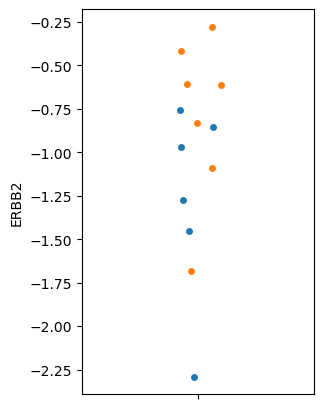

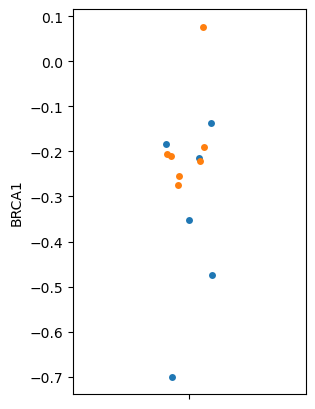

In [12]:
fig, ax = plt.subplots(1,1, figsize = (3,5))
sns.stripplot(dep_transposed.loc['ERBB2'][HER2_HOXB13_coamp])
sns.stripplot(dep_transposed.loc['ERBB2'][HER2only])


fig, ax = plt.subplots(1,1, figsize = (3,5))
sns.stripplot(dep_transposed.loc['BRCA1'][HER2_HOXB13_coamp])
sns.stripplot(dep_transposed.loc['BRCA1'][HER2only])


In [13]:

# Compare drug sensitivities between HER2/HOXB13 coamp, and HER2 only amp
# PRISM primary screen
# only 3 HER+HOXB13 lines, 2 HER2 only lines
prism_transposed = prism_primary.transpose()

HER2_HOXB13_coamp_prism = [x for x in HER2_HOXB13_coamp if x in prism_transposed.columns]
HER2only_prism = [x for x in HER2only if x in prism_transposed.columns]


prism_sensitivities = prism_transposed.apply(lambda x: ttest_ind(x[HER2_HOXB13_coamp_prism].dropna(), x[HER2only_prism].dropna(), nan_policy='omit').pvalue, axis=1).to_frame()
prism_sensitivities.columns = ['ttest_p']
prism_sensitivities['avg_HER2HOXB13'] = prism_sensitivities.apply(lambda x: np.nanmean(prism_transposed.loc[x.name][HER2_HOXB13_coamp_prism]), axis=1)
prism_sensitivities['avg_HER2only'] = prism_sensitivities.apply(lambda x: np.nanmean(prism_transposed.loc[x.name][HER2only_prism]), axis=1)
prism_sensitivities['difference'] = prism_sensitivities.apply(lambda x: x.avg_HER2HOXB13-x.avg_HER2only, axis=1)
prism_sensitivities['log10p'] = prism_sensitivities.apply(lambda x: -np.log10(x.ttest_p), axis=1)

# keep only drugs with p-value != NaN
#prism_sensitivities = prism_sensitivities.dropna()
#prism_sensitivities['qval'] = fdrcorrection(prism_sensitivities.ttest_p)[1]


/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_96159/116266167.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  prism_sensitivities = prism_transposed.apply(lambda x: ttest_ind(x[HER2_HOXB13_coamp_prism].dropna(), x[HER2only_prism].dropna(), nan_policy='omit').pvalue, axis=1).to_frame()
/Users/esther/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/esther/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_96159/116266167.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to c

/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_96159/116266167.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  prism_sensitivities = prism_transposed.apply(lambda x: ttest_ind(x[HER2_HOXB13_coamp_prism].dropna(), x[HER2only_prism].dropna(), nan_policy='omit').pvalue, axis=1).to_frame()
/Users/esther/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/esther/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/var/folders/bb/yb3gg4014bv4v88wmr3c_95c0000gq/T/ipykernel_96159/116266167.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to c

In [14]:
sample_info.loc[prism_transposed.columns] 

,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
ACH-000927,BT-474,BT474,BT474_BREAST,NaN,946359.0,Female,ATCC,CVCL_0179,412.0,breast,...,ERpos_HER2pos,HER2_amp,2D: adherent,NaN,NaN,PT-Az6j9u,NaN,Invasive breast carcinoma of no special type,C4194,NaN
ACH-000117,EFM-192A,EFM192A,EFM192A_BREAST,NaN,1290798.0,Female,DSMZ,CVCL_1812,1187.0,pleural_effusion,...,ERpos_HER2pos,HER2_amp,NaN,NaN,NaN,PT-qkpbqp,NaN,Breast carcinoma,C4872,NaN
ACH-000277,HCC1419,HCC1419,HCC1419_BREAST,NaN,907045.0,Female,ATCC,CVCL_1251,1551.0,breast,...,ERpos_HER2pos,HER2_amp,NaN,NaN,NaN,PT-osxHUh,NaN,Breast ductal carcinoma,C4017,NaN
ACH-000759,MDA-MB-175-VII,MDAMB175VII,MDAMB175VII_BREAST,NaN,908120.0,Female,ATCC,CVCL_1400,50.0,pleural_effusion,...,ERpos_HER2neg,HER2_amp,2D: adherent,NaN,NaN,PT-maODOx,NaN,Invasive breast carcinoma of no special type,C4194,NaN
ACH-000934,MDA-MB-361,MDAMB361,MDAMB361_BREAST,NaN,908121.0,Female,ATCC,CVCL_0620,880.0,central_nervous_system,...,ERpos_HER2pos,HER2_amp,2D: adherent,NaN,NaN,PT-0VWXIm,NaN,Breast adenocarcinoma,C5214,NaN


In [15]:
prism_sensitivities.sort_values(by='ttest_p')

,ttest_p,avg_HER2HOXB13,avg_HER2only,difference,log10p
tyrphostin-A9 (BRD:BRD-K40255344-001-17-6),0.000206,-1.400703,0.321119,-1.721822,3.686327
camptothecin (BRD:BRD-K37890730-001-15-1),0.000394,-3.946122,-2.320741,-1.625381,3.404842
methylprednisolone (BRD:BRD-K35240538-001-26-2),0.000699,-0.353321,0.676114,-1.029435,3.155543
beclomethasone-dipropionate (BRD:BRD-K97810537-001-12-8),0.002096,-0.610412,0.521368,-1.131780,2.678544
levodropropizine (BRD:BRD-K83551379-001-02-6),0.002387,0.102606,0.513653,-0.411047,2.622139
...,...,...,...,...,...
triciribine (BRD:BRD-K80431395-001-09-9),NaN,0.432328,0.410517,0.021812,NaN
erteberel (BRD:BRD-K80608265-001-01-6),NaN,0.326590,-0.467431,0.794021,NaN
PI-828 (BRD:BRD-K97365803-001-02-1),NaN,0.578125,0.245748,0.332377,NaN
BMS-626529 (BRD:BRD-K97883416-001-01-4),NaN,-0.314262,-0.402841,0.088579,NaN


AttributeError: 'DataFrame' object has no attribute 'qval'

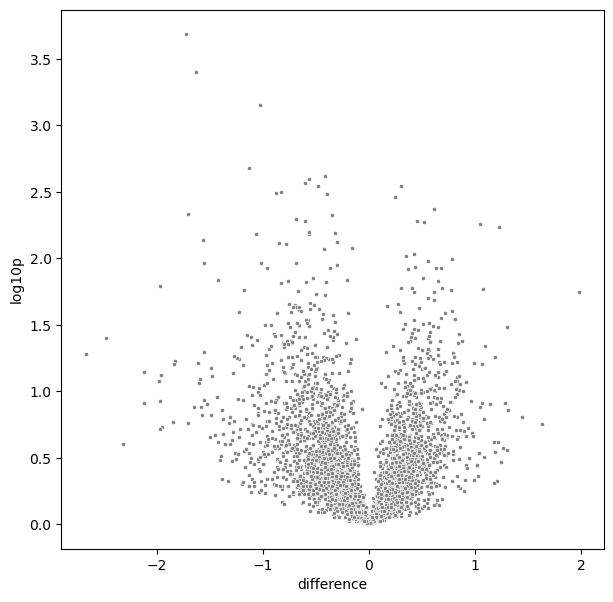

In [16]:
# volcano plot for dependencies 
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x = 'difference', y = 'log10p', data =prism_sensitivities, color='grey', marker = '.', ax=ax)
sns.scatterplot(x = 'difference', y = 'log10p', data = prism_sensitivities[prism_sensitivities.qval<0.1], color='red', label = 'q<0.01')

sns.despine()
ax.legend(loc='upper right', frameon=False, fontsize=14)
ax.set_ylabel('P-value ($\mathregular{-log_{10}}$)', fontsize=16)
ax.set_xlabel('PRISM drug sensitivity difference HER2+HOXB13/HER2 only', fontsize=16)


In [ ]:
prism_primary_treatment_info = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/primary-screen-replicate-treatment-info.csv', sep=',', header=0, index_col=0) 

prism_broad_id = [x.split(':')[1][:-1] for x in prism_sensitivities[prism_sensitivities.ttest_p<0.05].index]

prism_primary_treatment_info.loc[prism_primary_treatment_info.broad_id.isin(prism_broad_id)]

# There are multiple rows for each drug, just pick the first one
prism_sensitivities['moa'] = prism_sensitivities.apply(lambda x: prism_primary_treatment_info[prism_primary_treatment_info.broad_id==x.name.split(':')[1][:-1]].moa[0], axis=1)
prism_sensitivities.sort_values(by='difference')


In [ ]:
prism_sensitivities[abs(prism_sensitivities.difference) > 1].sort_values(by='difference').to_csv('/Users/esther/Downloads/test.tsv', sep='\t')
#prism_sensitivities.sort_values(by='difference')



In [ ]:
# Make GSEA compatible set of MOAs with their drugs, pre-file for GMT formatting in Excel
# https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/File:Gmt_format_snapshot.gif
df = prism_primary_treatment_info.groupby('moa')['broad_id'].agg({len, lambda x: set(x)})
df.to_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/PRISM_drug_moa.tsv', sep='\t')

In [ ]:
# Save table with differences in sensitivities between HER2+HOXB13 and HER2 only for GSEA pre-ranked analysis
prism_sensitivities['broad_id'] = prism_sensitivities.apply(lambda x: x.name.split(':')[1][:-1], axis = 1)
prism_sensitivities.sort_values(by='difference')[['broad_id','difference']].to_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/Drugs_ranked_by_difference_HER2_HOXB13_to_HER2only.rnk', sep='\t', index = False)

In [ ]:
prism_primary_with_class = prism_primary
prism_primary_with_class['HER2_class'] = prism_primary_with_class.apply(lambda x: 'HOXB13_HER2' if x.name in HER2_HOXB13_coamp else ('HER2only' if x.name in HER2only else 'NA'), axis=1)

In [ ]:
# Top hit sensitive in HER2/HOXB13 vs HER2 only lines
drugs = prism_sensitivities.sort_values(by='difference').index[0:5]
fig, ax = plt.subplots(1,5 ,figsize = (10,3))
i =0
for drug in drugs:
    sns.stripplot(x= 'HER2_class', y =  drug , data = prism_primary_with_class, ax = ax[i])
    sns.despine
    i+=1
plt.tight_layout()

In [ ]:
# Top hit sensitive in HER2 only vs HER2/HOXB13 lines
drugs = prism_sensitivities.sort_values(by='ttest_p', ascending=True).index[0:10]
fig, ax = plt.subplots(1,10 ,figsize = (20,3))
i =0
for drug in drugs:
    sns.stripplot(x= 'HER2_class', y =  drug , data = prism_primary_with_class, ax = ax[i])
    sns.despine
    i+=1
plt.tight_layout()

In [ ]:
# consider sensitive values only. From Steven Corsello's Nature Cancer paper: 
# "We label cell lines as sensitive to a treatment if the median-collapsed fold-change is less than 0.3."


for drug in prism_sensitivities[prism_sensitivities.ttest_p<0.05].index:
    if (prism_sensitivities.loc[drug].difference>1):
        fig, ax = plt.subplots(1,1, figsize = (3,5))
        sns.stripplot(x= 'HER2_class', y = drug, data = prism_primary_with_class )
        sns.despine()

In [ ]:
drug = 'afatinib (BRD:BRD-K66175015-001-09-0)'
fig, ax = plt.subplots(1,1, figsize = (3,5))
sns.stripplot(x= 'HER2_class', y = drug, data = prism_primary_with_class )
sns.despine()
prism_primary_treatment_info[prism_primary_treatment_info.broad_id=='BRD-K17368287-001-18-3']

In [ ]:
# run GSEA on raw dataset
prism_transposed['broad_id'] = prism_transposed.apply(lambda x: x.name.split(':')[1][:-1], axis=1)
prism_transposed.to_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/PRISM_primary_transposed_for_GSEA.txt', sep='\t')

In [ ]:
# HER2/HOXB13 more sensitive, HER2 only not sensitive
prism_sensitivities[(prism_sensitivities.avg_HER2HOXB13< -1.7) & (prism_sensitivities.avg_HER2only> 0)]


In [ ]:
for drug in prism_sensitivities[(prism_sensitivities.avg_HER2HOXB13< -1.7) & (prism_sensitivities.avg_HER2only> 0)].index:
    fig, ax = plt.subplots(1,1, figsize = (3,5))
    sns.stripplot(x= 'HER2_class', y = drug, data = prism_primary_with_class )
    sns.despine()


In [ ]:
# HER2 only , HER2/HOAB13 only sensitive

prism_sensitivities[(prism_sensitivities.avg_HER2HOXB13 > -0.65) & (prism_sensitivities.avg_HER2only < -1.7)]


In [ ]:
PRISM_secondary = pd.read_csv('/Users/esther/Documents/Projects/2019/Sgroi_HOXB13/DepMap_data/Drug_sensitivity_replicate-level_dose_(PRISM_Repurposing_Secondary_Screen)_subsetted_NAsdropped.csv', sep=',', header=0)
PRISM_secondary

In [ ]:
# Skyros internal PRSIM oncology reference data

prism_onc_AUC = pd.read_csv('/Users/esther/Documents/Reference_data/DepMap/Skyros/onc-ref-001-_v2-auc-matrix.tsv', sep='\t', header=0, index_col=0)

In [ ]:
prism_onc_AUC_HER2_HOXB13_coamp = [x for x in HER2_HOXB13_coamp if x in prism_onc_AUC.columns]

prism_onc_AUC_HER2only = [x for x in HER2only if x in prism_onc_AUC.columns]

prism_onc_AUC_HER2only


In [ ]:
# Compare sensitivities between HER2/HOXB13 coamp, and HER2 only amp
# Dependency analysis
AUC_transposed = prism_onc_AUC
diff_AUC = prism_onc_AUC.apply(lambda x: ttest_ind(x[prism_onc_AUC_HER2_HOXB13_coamp].dropna(), x[prism_onc_AUC_HER2only].dropna(), nan_policy='omit').pvalue, axis=1).to_frame()
diff_AUC.columns = ['ttest_p']
diff_AUC['avg_HER2HOXB13'] = diff_AUC.apply(lambda x: np.nanmean(AUC_transposed.loc[x.name][prism_onc_AUC_HER2_HOXB13_coamp]), axis=1)
diff_AUC['avg_HER2only'] = diff_AUC.apply(lambda x: np.nanmean(AUC_transposed.loc[x.name][prism_onc_AUC_HER2only]), axis=1)
diff_AUC['difference'] = diff_AUC.apply(lambda x: x.avg_HER2HOXB13-x.avg_HER2only, axis=1)
diff_AUC.dropna(inplace=True)
diff_AUC['qval'] = fdrcorrection(diff_AUC.ttest_p)[1]
diff_AUC['log10p'] = diff_AUC.apply(lambda x: -np.log10(x.ttest_p), axis=1)


In [ ]:
compounds = pd.read_csv('/Users/esther/Documents/Reference_data/DepMap/Skyros/onc-ref-001-_v2-compound-list.tsv', sep='\t', header=0, index_col=0)
# some compounds have multiple IDs
compounds['First_ID'] = compounds.apply(lambda x: x.IDs.split(';')[0], axis=1)
compounds['Last_ID'] = compounds.apply(lambda x: x.IDs.split(';')[-1], axis=1)

# volcano plot for onc AUC differences
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x = 'difference', y = 'log10p', data =diff_AUC, color='grey', marker = '.', ax=ax)

sns.despine()
ax.legend(loc='upper right', frameon=False, fontsize=14)
ax.set_ylabel('P-value ($\mathregular{-log_{10}}$)', fontsize=16)
ax.set_xlabel('PRISM drug sensitivity difference HER2+HOXB13/HER2 only', fontsize=16)



for index,row in diff_AUC[diff_AUC.log10p>1].iterrows():
    if index == 'BRD:BRD-U00115289-001-01-9':
        name = 'SN38'
    else:
        name = compounds[compounds.First_ID==index].index[0]
    ax.text(row.difference, row.log10p, name)
    

In [ ]:
merged = pd.merge(diff_AUC, compounds, left_index = True, right_on = 'IDs')

merged[abs(merged.difference)>0.2].sort_values(by='ttest_p', ascending=True)

In [ ]:
#plt.boxplot(prism_onc_AUC.loc['BRD:BRD-K64881305-001-01-1'][HER2_HOXB13_coamp_prism], prism_onc_AUC.loc['BRD:BRD-K64881305-001-01-1'][HER2only_prism])
print(prism_onc_AUC.loc['BRD:BRD-K64881305-001-01-1'][HER2_HOXB13_coamp_prism])

print(prism_onc_AUC.loc['BRD:BRD-K64881305-001-01-1'][HER2only_prism])